# Quantitative trading strategies implementation and comparison

- Moving average strategies (single and double SMA crossovers)
- RSI overbought and oversold strategies
- Bollinger Bands Strategy
- MACD strategy
- Strategy Portfolio and Performance Evaluation

In [5]:
# import libraries for data manipulation, plotting, and finance ayalysis
import numpy as np # numerical operations
import pandas as pd # data manipulation
import matplotlib.pyplot as plt # plotting
import seaborn as sns # stat data visualization
import yfinance as yf # fetch financial data from Yahoo
from datetime import datetime, timedelta # for working with dates and times

import backtrader as bt # for back-testing

# for modifying system path
import sys
sys.path.append('..')

# set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

# set pandas option to display all columns in DataFrames
pd.set_option('display.max_columns', None)

## Access to market data

Use the yfinance library to get historical data for backtesting:


In [7]:
# define parameters for the back-testing
ticker_symbol = "000426.sz"
start_date = '2022-05-01'
end_date = '2025-05-01'

# download the stock data using the YFiance library
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
print(f"Sucessfully downloaded {ticker_symbol} data from {start_date} to {end_date}, with{len(stock_data)} trading days.")
stock_data.head()


# covert the multiIndex columns to a simpler one-level index
stock_data.columns = stock_data.columns.get_level_values(0)
print("Flattened data：")
print(stock_data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Sucessfully downloaded 000426.sz data from 2022-05-01 to 2025-05-01, with727 trading days.
Flattened data：
Price          Close      High       Low      Open    Volume
Date                                                        
2022-05-05  6.416702  6.545831  6.317373  6.456434  22493707
2022-05-06  6.128646  6.237909  6.059115  6.237909  21099947
2022-05-09  6.337239  6.376971  6.049183  6.059115  19674537
2022-05-10  6.337239  6.347172  6.118713  6.257775  15593351
2022-05-11  6.218043  6.426635  6.208110  6.297507  20031769


In [8]:
# select specific columns from stock data
stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]

## Prepare backtest data

Convert the data to a format usable by Backtrader:

In [10]:
# saving the data to CVS
csv_file = f"{ticker_symbol}_data.csv"
stock_data.to_csv(csv_file)

# helper function to create backtrader data feed
# converts the CSV data into a format that can be used by Backtrader for back-testing
def create_bt_data_feed(csv_file):
    return bt.feeds.YahooFinanceCSVData(
        dataname=csv_file,
        fromdate=datetime.strptime(start_date, '%Y-%m-%d'), # start date
        todate=datetime.strptime(end_date, '%Y-%m-%d'), # end date
        reverse=False
    )
    
# helper function to run the Backtest
# sets up backtest parameters and runs the strategy
def run_backtest(strategy_class, data_feed, cash=100000.0, commission=0.001, **strategy_params):
    # initialize the Cerebro engine for backtesting
    cerebro = bt.Cerebro()   
    # add data feed to Cerebro
    cerebro.adddata(data_feed)
    # add strategy to Cerebro
    cerebro.addstrategy(strategy_class, **strategy_params)
    
    # set the initial capital and commission
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission)
    
    # add ayalyzers to evaluate strategy performance
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    
    # running the strategy
    initial_value = cerebro.broker.getvalue()
    print(f'Initial Capital: ${initial_value:.2f}')
    
    results = cerebro.run()
    strategy = results[0]
    
    # get the final capital and gain/loss
    final_value = cerebro.broker.getvalue()
    print(f'Final Capital: ${final_value:.2f}')
    print(f'Gain/Loss: ${final_value - initial_value:.2f} ({(final_value / initial_value - 1) * 100:.2f}%)')
    
    # analyze performance
    print('\n--- Performance indicators ---')
    print(f'Sharpe Ratio: {strategy.analyzers.sharpe.get_analysis()["sharperatio"]:.4f}')
    print(f'Maximum Drawdown: {strategy.analyzers.drawdown.get_analysis()["max"]["drawdown"]:.2f}%')
    print(f'Annualized Return: {strategy.analyzers.returns.get_analysis()["rnorm100"]:.2f}%')
    
    return cerebro, strategy, results

## Moving Average Crossover Strategy Backtest

Implement and backtest a moving average strategy:

In [12]:
# define the MovingAverageCrossStrategy class
class MovingAverageCrossStrategy(bt.Strategy):
    """
    buy: short-term moving average crosses abover long-term line
    sell: SMA fast crosses below SMA slow
    """
    params = ( 
        ('fast_period', 20), # SMA fast period
        ('slow_period', 50), # SMA slow period
        ('printlog', True), # whether to print logs or not
    )
    
    # log function to print log messages
    def log(self, txt, dt=None):
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')
    
    # initialization function
    def __init__(self):
        self.order = None
        
        # Moving average: calculate fast and slow moving averages
        self.fast_ma = bt.indicators.SimpleMovingAverage(
            self.datas[0].close, period=self.params.fast_period
        )
        self.slow_ma = bt.indicators.SimpleMovingAverage(
            self.datas[0].close, period=self.params.slow_period
        ) 
        
        # crossover indicator to track when the fast and slow moving averages cross
        self.crossover = bt.indicators.CrossOver(self.fast_ma, self.slow_ma)
    
    # define the function to log order status
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'Buy Executed, Price: {order.executed.price:.2f}, Size: {order.executed.size}')
            else:
                self.log(f'Sell Executed, Price: {order.executed.price:.2f}, Size: {order.executed.size}')
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Rejected')
        
        # reset order
        self.order = None
    
    # function for strategy execution
    def next(self):
        # if there is an existing order, do nothing
        if self.order:
            return
        
        # if there is no position, and fast MA crosses above slow MA, then buy
        if not self.position:
            if self.crossover > 0:
                cash = self.broker.getcash()
                price = self.datas[0].close[0]
                size = int(cash // price)
                if size > 0:
                    self.log(f'Buy Signal (fast_ma>slow_ma), Buy: {size} shares')
                    self.order = self.buy(size=size)
        else:
            # if there is position, check for sell signal
            if self.crossover < 0:
                self.log(f'Sell Signal (fast_ma<slow_ma), Sell: {self.position.size} shares')
                self.order = self.sell(size=self.position.size)
    
    # function to display results
    def stop(self):
        self.log(f'End Strategy, Portfolio Value: {self.broker.getvalue():.2f}')

In [13]:
# set up and run the back-testing

# Create the Cerebro back-testing engine
cerebro = bt.Cerebro()
cerebro.broker.setcash(100000.0)  # set initial capital

# add the strategy to Cerebro and enable logging for debugging
cerebro.addstrategy(MovingAverageCrossStrategy, fast_period=20, slow_period=50, printlog=True)

# create the data feed and add it to Cerebro
data_feed = bt.feeds.PandasData(dataname=stock_data)
cerebro.adddata(data_feed)

# print initial capital
print('Initial Capital: %.2f' % cerebro.broker.getvalue())

# run the back-testing
cerebro.run()

# print final capital
print('Final Capital: %.2f' % cerebro.broker.getvalue())

# ---------------------------
# 4. plot the result
# ---------------------------
# enable inline plotting for Jupyter Notebooks
%matplotlib inline
# plot the results with candlestick chart style
cerebro.plot(style='candlestick',iplot = False)

Initial Capital: 100000.00
2022-11-23, Buy Signal (fast_ma>slow_ma), Buy: 16612 shares
2022-11-24, Order Canceled/Rejected
2023-01-20, Buy Signal (fast_ma>slow_ma), Buy: 15440 shares
2023-01-30, Order Canceled/Rejected
2023-09-21, Buy Signal (fast_ma>slow_ma), Buy: 10803 shares
2023-09-22, Buy Executed, Price: 9.26, Size: 10803
2023-11-13, Sell Signal (fast_ma<slow_ma), Sell: 10803 shares
2023-11-14, Sell Executed, Price: 9.01, Size: -10803
2024-01-11, Buy Signal (fast_ma>slow_ma), Buy: 10569 shares
2024-01-12, Buy Executed, Price: 9.21, Size: 10569
2024-02-05, Sell Signal (fast_ma<slow_ma), Sell: 10569 shares
2024-02-06, Sell Executed, Price: 7.37, Size: -10569
2024-03-12, Buy Signal (fast_ma>slow_ma), Buy: 8055 shares
2024-03-13, Buy Executed, Price: 9.60, Size: 8055
2024-07-04, Sell Signal (fast_ma<slow_ma), Sell: 8055 shares
2024-07-05, Sell Executed, Price: 13.24, Size: -8055
2024-07-16, Buy Signal (fast_ma>slow_ma), Buy: 7070 shares
2024-07-17, Order Canceled/Rejected
2024-10-18,

[[<Figure size 1400x700 with 5 Axes>]]

## RSI strategy backtest

### Implement and backtest RSI-based trading strategies:

In [15]:
# this strategy uses RSI indicator to generate buy/sell signals
# buy when RSI < rsi_low, oversold
# sell when RSI > rsi_high, overbought

class RSIStrategy(bt.Strategy):
    params = (  
        ('rsi_period', 14),
        ('rsi_low', 30),
        ('rsi_high', 70),
        ('printlog', True),
    )
    
    # custom logging function with timestamp
    def log(self, txt, dt=None):
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')
    
    # initialize strategy indicators and variables
    def __init__(self):
        self.order = None
        # create RSI indicator using colse prices
        self.rsi = bt.indicators.RSI_SMA(self.datas[0], period=self.params.rsi_period)
    
    # handle order status notifications
    def notify_order(self, order):
        # check if order is submitted or accepted
        if order.status in [order.Submitted, order.Accepted]:
            return
        # order completed
        if order.status in [order.Completed]:
            if order.isbuy():
                # buy order executed
                self.log(f'Buy Executed, Price: {order.executed.price:.2f}, Shares: {order.executed.size}') 
            else:
                # sell order executed
                self.log(f'Sell Executed, Price: {order.executed.price:.2f}, Shares: {order.executed.size}')
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            # order was cancelled or rejected
            self.log('Order Cancelled/Rejected')
        # reset order tracking
        self.order = None
    
    # main strategy logic executed on each bar
    def next(self):
        # get current price and RSI value
        price = self.datas[0].close[0]
        rsi_value = self.rsi[0]
        # log current market data
        self.log(f'Close Price: {price:.2f}, RSI: {rsi_value:.2f}')

        # skip if there is a pending order
        if self.order:
            return
        
        # buy logic: enter position when RSI < 30, oversold
        if not self.position:
            if rsi_value < self.params.rsi_low:
                # calculate position size based on available cash
                cash = self.broker.getcash()
                # calculate shares we can afford
                size = int(cash // price)
                if size > 0:
                    self.log(f'Buy Signal (RSI<{self.params.rsi_low}), Buying All: {size}shares')
                    self.order = self.buy(size=size)
        else:
            # sell logic: exit position when RSI > 70, overbought
            if rsi_value > self.params.rsi_high: 
                self.log(f'Sell Signal (RSI>{self.params.rsi_high}), Selling All: {self.position.size}shares')
                self.order = self.sell(size=self.position.size)
    
    # called when strategy execution ends
    def stop(self):
        self.log(f'Strategy ended, Final Portfolio Value: {self.broker.getvalue():.2f}')


In [27]:
# create and run backtrader engine

# create the main backtesting engine
cerebro = bt.Cerebro()

# set initial capital
cerebro.broker.setcash(100000.0)

# add data source
# create date feed from pandas Dataframe containing stock data
data_feed = bt.feeds.PandasData(dataname=stock_data)
cerebro.adddata(data_feed)

# add trading strategy
cerebro.addstrategy(RSIStrategy, rsi_period=14, rsi_low=30, rsi_high=70, printlog=True)

# print initial portfolio value
print(f'Starting Portfolio Value: ${cerebro.broker.getvalue():.2f}')

# run backtest
results = cerebro.run()
final_value = cerebro.broker.getvalue()
print(f'Backtest ended，Final Portfolio Value: ${final_value:.2f}')
initial_cash = 100000
total_return = ((final_value - initial_cash) / initial_cash) * 100
print(f'Total Return: {total_return:.2f}%')

Starting Portfolio Value: $100000.00
2022-05-25, Close Price: 6.16, RSI: 42.26
2022-05-26, Close Price: 6.17, RSI: 51.43
2022-05-27, Close Price: 6.12, RSI: 41.13
2022-05-30, Close Price: 6.13, RSI: 41.60
2022-05-31, Close Price: 6.26, RSI: 51.59
2022-06-01, Close Price: 6.23, RSI: 53.72
2022-06-02, Close Price: 6.25, RSI: 54.92
2022-06-06, Close Price: 6.36, RSI: 63.93
2022-06-07, Close Price: 6.32, RSI: 61.90
2022-06-08, Close Price: 6.40, RSI: 63.91
2022-06-09, Close Price: 6.32, RSI: 61.15
2022-06-10, Close Price: 6.47, RSI: 59.70
2022-06-13, Close Price: 6.55, RSI: 56.45
2022-06-14, Close Price: 6.66, RSI: 80.20
2022-06-15, Close Price: 6.59, RSI: 72.16
2022-06-16, Close Price: 6.55, RSI: 69.00
2022-06-17, Close Price: 6.71, RSI: 76.79
2022-06-20, Close Price: 6.70, RSI: 75.89
2022-06-21, Close Price: 6.53, RSI: 61.54
2022-06-22, Close Price: 6.48, RSI: 60.50
2022-06-23, Close Price: 6.56, RSI: 62.40
2022-06-24, Close Price: 6.60, RSI: 60.17
2022-06-27, Close Price: 6.77, RSI: 67.

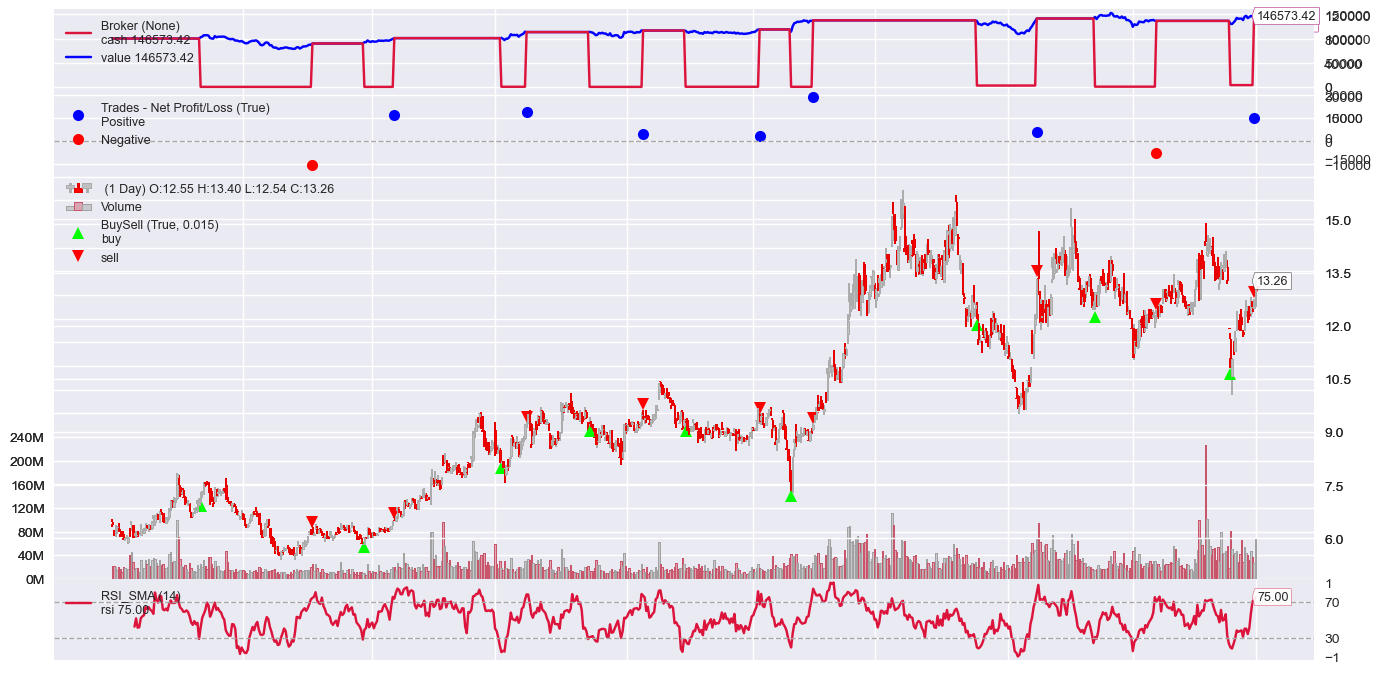

[[<Figure size 1750x875 with 10 Axes>]]

In [29]:
# import matplotlib
%matplotlib inline
# plot backtest results with candletick chart
cerebro.plot(style='candlestick', iplot=False)

## Bollinger Band Strategy Backtest

### Implement and backtest a Bollinger Band based trading strategy:

In [32]:
# 2. define Bollinger bands strategy, full position trading

class BollingerBandsStrategy(bt.Strategy):
    # this strategy uses Bollinger Bands to generate buy/sell signals:
    # buy when price breaks below the lower band -> oversold
    # sell when price breaks above the upper band -> overbought
   
    params = (
        ('period', 20),
        ('devfactor', 2.0),
        ('printlog', True),
    )
    
    # custom logging function with timestamp
    def log(self, txt, dt=None):
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')
    
    # initialize strategy indicators and variables
    def __init__(self):
        # initialize order tracking
        self.order = None
        # create bollinger bands indicator
        self.boll = bt.indicators.BollingerBands(
            self.datas[0],
            period=self.params.period,
            devfactor=self.params.devfactor
        )
    
    # handle order status notifications
    def notify_order(self, order):
        # skip if order is still pending
        if order.status in [order.Submitted, order.Accepted]:
            return
        # handle completed orders
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'Buy Executed, Price: {order.executed.price:.2f}, Shares: {order.executed.size}')
            else:
                self.log(f'Sell Executed, Price: {order.executed.price:.2f}, Shares: {order.executed.size}')
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Cancelled/Rejected')
        # order was cancelled or rejected
        self.order = None
    
    # main strategy logic executed on each bar
    def next(self):
        # get current market data
        close_price = self.datas[0].close[0]
        top = self.boll.top[0]
        bot = self.boll.bot[0]
        # log current market conditions
        self.log(f'Close Price: {close_price:.2f}, Upper Band: {top:.2f}, Lower Band: {bot:.2f}')
        # skip if there is a pending order
        if self.order:
            return
        # entry logic
        if not self.position:
            # price breaks below lower band, full position buy
            if close_price < bot:
                cash = self.broker.getcash()
                size = int(cash // close_price)
                if size > 0:
                    self.log(f'Buy Signal (Close Price < Lower Band), Buy: {size}shares')
                    self.order = self.buy(size=size)
        else:
            # price breaks above upper band, full position sell
            if close_price > top:
                self.log(f'Sell Signal (Close Price > Upper Band), Sell: {self.position.size}share')
                self.order = self.sell(size=self.position.size)
    
    # called when strategy execution ends
    def stop(self):
        self.log(f'Strategy ended，Final Portfolio Value: {self.broker.getvalue():.2f}')

# 3. define Custom Analyzer for recording equity curve
class EquityCurveAnalyzer(bt.Analyzer):
    # this analyzer records the portfolio equity value at each time step,
    # allowing us to plot and analyze the equity curve performance

    # initialize analyzer data structures
    def start(self):
        self.equity = [] # list to store portfolio values
        self.dates = [] # list to store corresponding dates
    
    # called on each bar to record current portfolio status
    def next(self):
        # record current portfolio value at each bar
        self.equity.append(self.strategy.broker.getvalue())
        # get current datetime and convert to date object
        dt = self.strategy.datas[0].datetime.date(0)
        self.dates.append(dt)

    # return collected data for external analysis
    def get_analysis(self):
        return {'dates': self.dates, 'equity': self.equity}

# 4. create and run backtest engine
cerebro = bt.Cerebro()

# set initial capital for backtesting
initial_capital = 100000
cerebro.broker.setcash(initial_capital)

# add data source
# create pandas data feed from stock data
data_feed = bt.feeds.PandasData(dataname=stock_data)
cerebro.adddata(data_feed)

# add bollinger bands trading strategy
cerebro.addstrategy(
    BollingerBandsStrategy,
    period=20,
    devfactor=2.0,
    printlog=True
)

# add equity curve analyzer to track portfolio performance
cerebro.addanalyzer(EquityCurveAnalyzer, _name='equitycurve')

# print initial portfolio value
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

# run backtest
results = cerebro.run()
final_value = cerebro.broker.getvalue()
print(f'Backtest Completed，Final Portfolio Value: {final_value:.2f}')
total_return = ((final_value - initial_capital) / initial_capital) * 100
print(f'Total Return: {total_return:.2f}%')

# extract equity curve analysis data
equity_analyzer = results[0].analyzers.equitycurve.get_analysis()
dates = equity_analyzer['dates']
equity = equity_analyzer['equity']

Starting Portfolio Value: 100000.00
2022-06-01, Close Price: 6.23, Upper Band: 6.42, Lower Band: 5.93
2022-06-02, Close Price: 6.25, Upper Band: 6.38, Lower Band: 5.95
2022-06-06, Close Price: 6.36, Upper Band: 6.41, Lower Band: 5.94
2022-06-07, Close Price: 6.32, Upper Band: 6.41, Lower Band: 5.95
2022-06-08, Close Price: 6.40, Upper Band: 6.42, Lower Band: 5.94
2022-06-09, Close Price: 6.32, Upper Band: 6.43, Lower Band: 5.94
2022-06-10, Close Price: 6.47, Upper Band: 6.47, Lower Band: 5.93
2022-06-13, Close Price: 6.55, Upper Band: 6.53, Lower Band: 5.91
2022-06-14, Close Price: 6.66, Upper Band: 6.60, Lower Band: 5.90
2022-06-15, Close Price: 6.59, Upper Band: 6.64, Lower Band: 5.92
2022-06-16, Close Price: 6.55, Upper Band: 6.67, Lower Band: 5.95
2022-06-17, Close Price: 6.71, Upper Band: 6.72, Lower Band: 5.97
2022-06-20, Close Price: 6.70, Upper Band: 6.77, Lower Band: 5.97
2022-06-21, Close Price: 6.53, Upper Band: 6.78, Lower Band: 5.97
2022-06-22, Close Price: 6.48, Upper Ban

In [34]:
!pip install plotly

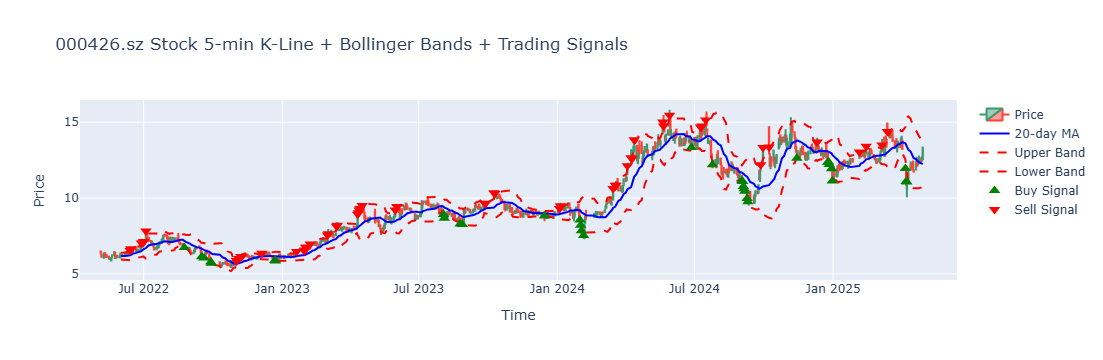

In [36]:
import plotly.graph_objects as go

# calculate bollinger band indicators
# 20-day simple moving average
stock_data['MA20'] = stock_data['Close'].rolling(20).mean()
# upper band: MA + 2 * 20-day standard deviation
stock_data['Upper'] = stock_data['MA20'] + (stock_data['Close'].rolling(20).std() * 2)
# lower band: MA - 2 * 20-day standard deviation
stock_data['Lower'] = stock_data['MA20'] - (stock_data['Close'].rolling(20).std() * 2)

# generate trading signals based on bollinger bands
buy_signals = stock_data[stock_data['Close'] < stock_data['Lower']]
sell_signals = stock_data[stock_data['Close'] > stock_data['Upper']]

# create interactive plotly figure
fig = go.Figure()

# add Candlestick chart for price data
fig.add_trace(go.Candlestick(
    x=stock_data.index,
    open=stock_data['Open'],
    high=stock_data['High'],
    low=stock_data['Low'],
    close=stock_data['Close'],
    name='Price'
))

# add bollinger bands lines
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['MA20'], mode='lines', name='20-day MA', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Upper'], mode='lines', name='Upper Band', line=dict(color='red', dash='dash')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Lower'], mode='lines', name='Lower Band', line=dict(color='red', dash='dash')))

# add buy signals, green triangles pointing up
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['Close'],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', color='green', size=10)
))

# add sell signals, red triangles pointing down
fig.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['Close'],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', color='red', size=10)
))

# customize char layout and appearance
fig.update_layout(
    title=f"{ticker_symbol} Stock 5-min K-Line + Bollinger Bands + Trading Signals",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False
)

fig.show()

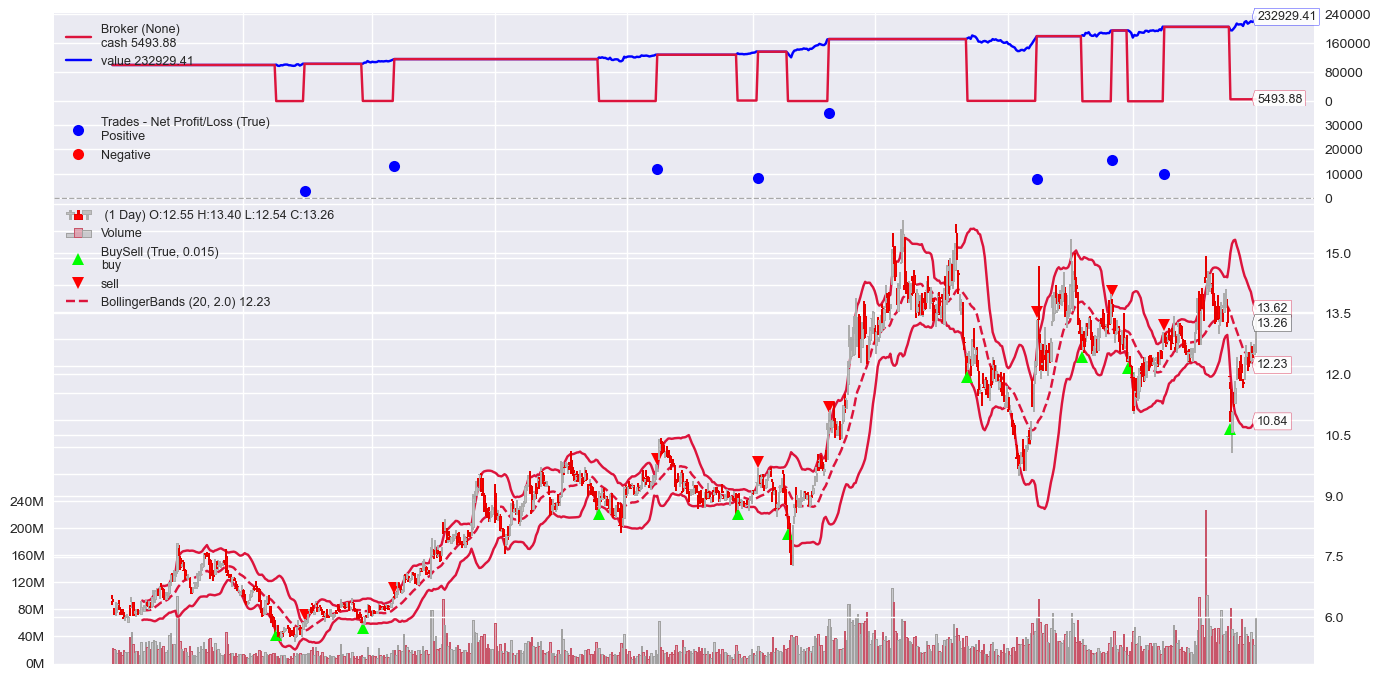

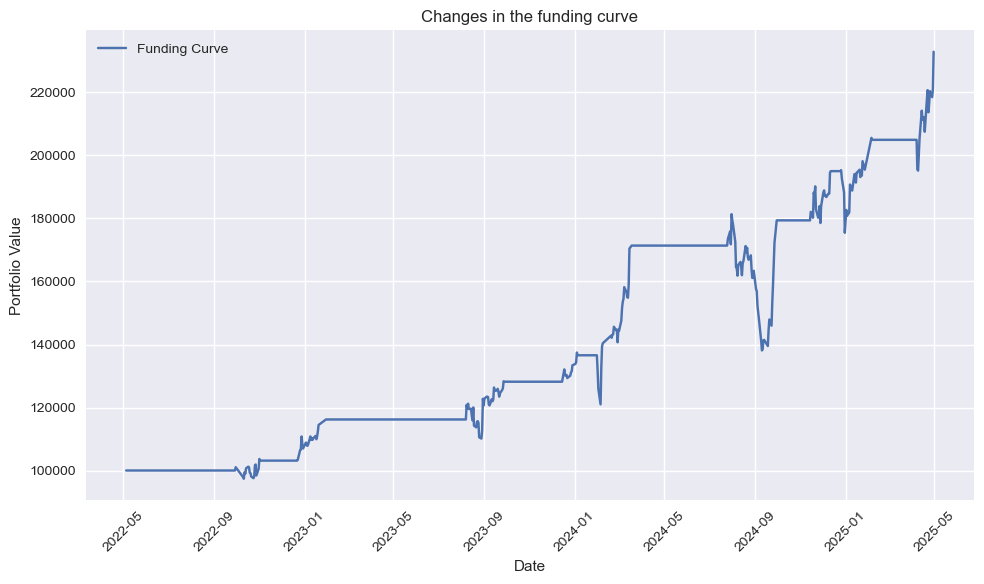

In [42]:
# 5. Plotting backtest results and funding curves

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False


# Using Backtrader's Built-in Drawing
%matplotlib inline
cerebro.plot(style='candlestick', iplot=False)

# Plotting the funding curve
plt.figure(figsize=(10,6))
plt.plot(dates, equity, label='Funding Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Changes in the funding curve')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## MACD Strategy Backtest

### Implemented and backtested a MACD-based trend-following strategy:

In [45]:
# 2. define MACD strategy, full position in/out

class MACDStrategy(bt.Strategy):

    params = (
        ('fastperiod', 12),
        ('slowperiod', 26),
        ('signalperiod', 9), 
        ('printlog', True),
    )
    
    # function to print messages with date
    def log(self, txt, dt=None):
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')
    
    def __init__(self):
        self.order = None
        
        # in backtrader, the MACD indicator returns 3 lines: MACD, signal, and hist
        self.macd_ind = bt.indicators.MACD(
            self.datas[0].close,
            period_me1=self.p.fastperiod,
            period_me2=self.p.slowperiod,
            period_signal=self.p.signalperiod
        )
        
        # we only need to check for crossovers btw the MACD line and the Signal line
        # > 0 means MACD crosses above, we buy; < 0 means acrosses below, we sell
        self.macd_crossover = bt.indicators.CrossOver(self.macd_ind.macd, self.macd_ind.signal)
    
    # callback to notify order status changes
    def notify_order(self, order):
        # order is not yet executed
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'Buy Executed, Price: {order.executed.price:.2f}, Shares: {order.executed.size}')
            else:
                self.log(f'Sell Executed, Price: {order.executed.price:.2f}, Shares: {order.executed.size}')
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order cancelled/rejected')
        # reset order status
        self.order = None
    
    def next(self): 
        # skip if there is already a pending order
        if self.order:
            return
        
        # if not currently in position, and MACD crosses above signal, then buy
        if not self.position:
            if self.macd_crossover > 0:
                cash = self.broker.getcash()
                price = self.datas[0].close[0] 
                size = int(cash // price)
                if size > 0:
                    self.log(f'Buy Signal (MACD>Signal), Buy: {size}shares, Close Price: {price:.2f}')
                    self.order = self.buy(size=size)
        else:
            # if MACD crosses below signal, then sell all
            if self.macd_crossover < 0:
                self.log(f'Sell Signal (MACD<Signal), Sell: {self.position.size}shares')
                self.order = self.sell(size=self.position.size)
    
    # called at the end of the strategy
    def stop(self):
        self.log(f'Strategy ended, Final Portfolio Value: {self.broker.getvalue():.2f}')

Initial Portfolio Value: 100000.00
2022-06-27, Buy Signal (MACD>Signal), Buy: 14761shares, Close Price: 6.77
2022-06-28, Order cancelled/rejected
2022-07-26, Buy Signal (MACD>Signal), Buy: 13678shares, Close Price: 7.31
2022-07-27, Buy Executed, Price: 7.28, Shares: 13678
2022-08-03, Sell Signal (MACD<Signal), Sell: 13678shares
2022-08-04, Sell Executed, Price: 7.14, Shares: -13678
2022-09-09, Buy Signal (MACD>Signal), Buy: 14652shares, Close Price: 6.69
2022-09-13, Order cancelled/rejected
2022-09-23, Buy Signal (MACD>Signal), Buy: 15407shares, Close Price: 6.37
2022-09-26, Buy Executed, Price: 6.29, Shares: 15407
2022-09-26, Sell Signal (MACD<Signal), Sell: 15407shares
2022-09-27, Sell Executed, Price: 6.08, Shares: -15407
2022-10-18, Buy Signal (MACD>Signal), Buy: 16555shares, Close Price: 5.73
2022-10-19, Buy Executed, Price: 5.73, Shares: 16555
2022-11-23, Sell Signal (MACD<Signal), Sell: 16555shares
2022-11-24, Sell Executed, Price: 6.07, Shares: -16555
2022-12-01, Buy Signal (MA

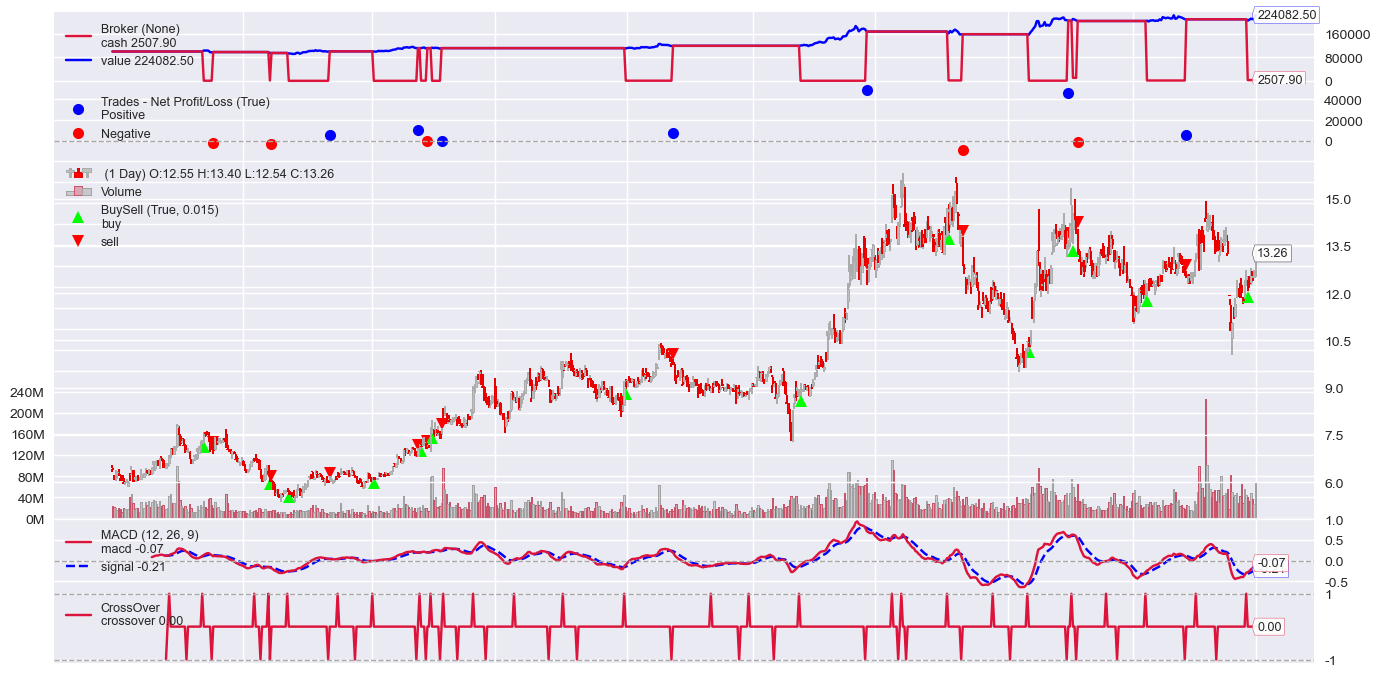

[[<Figure size 1400x700 with 6 Axes>]]

In [47]:
# 3. create and run the backtest engine

# instantiate the backtest engine
cerebro = bt.Cerebro()
# set the initial capital
cerebro.broker.setcash(100000.0)
# load stock data using pandas data feed
data_feed = bt.feeds.PandasData(dataname=stock_data)
cerebro.adddata(data_feed)

# add the strategy with specified parameters
cerebro.addstrategy(MACDStrategy,
                    fastperiod=12,
                    slowperiod=26,
                    signalperiod=9,
                    printlog=True)

print(f'Initial Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
final_value = cerebro.broker.getvalue()
print(f'Backtest ended, Final Portfolio Value: {final_value:.2f}')

# Plot the backtest result as a candlestick chart
%matplotlib inline
cerebro.plot(style='candlestick',iplot=False)

## Buy & Hold Strategy Backtesting

### Implement and backtest Buy & Hold strategies:

In [50]:
# buys once at the begining and holds till the end
class BuyHoldStrategy(bt.Strategy):
    params = (
        ('printlog', True),
    )
    
    def log(self, txt, dt=None):
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')
    
    def __init__(self):
        # used to track order status
        self.order = None

    def next(self):
        # if not already in a position, buy using all available cash
        if not self.position:
            cash = self.broker.getcash()
            price = self.datas[0].close[0]
            size = int(cash // price)
            
            if size > 0:
                self.order = self.buy(size=size)

    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'Buy executed, Price: {order.executed.price:.2f}')
            elif order.issell():
                self.log(f'Sell executed, Price: {order.executed.price:.2f}')
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order cancelled/rejected')
        
        self.order = None
    
    def stop(self):
        self.log(f'Strategy ended, Final Portfolio Value: {self.broker.getvalue():.2f}')

Start Portfolio Value: 100000.00
2022-05-06, Buy executed, Price: 6.24
2025-04-30, Strategy ended, Final Portfolio Value: 209432.27
Final Portfolio Value: 209432.27


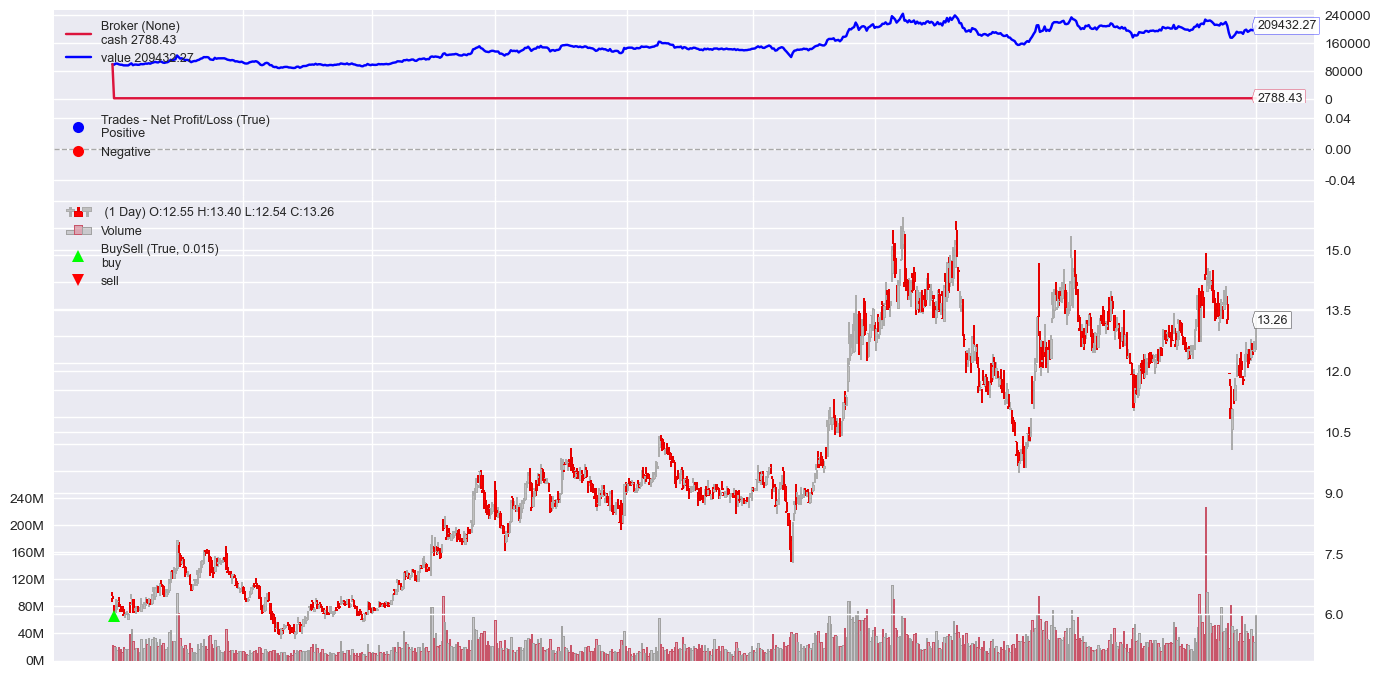

[[<Figure size 1400x700 with 4 Axes>]]

In [52]:
# 3. create and run the backtest engine

# initialize the backtest engine
cerebro = bt.Cerebro()
# set initial capital
cerebro.broker.setcash(100000.0)
# load stock data from the pandas dataFrame
data_feed = bt.feeds.PandasData(dataname=stock_data)
cerebro.adddata(data_feed)
# add the strategy
cerebro.addstrategy(BuyHoldStrategy, printlog=True)

print(f'Start Portfolio Value: {cerebro.broker.getvalue():.2f}')
results = cerebro.run()
final_value = cerebro.broker.getvalue()
print(f'Final Portfolio Value: {final_value:.2f}')

# 4. plot the backtest results using canlestick chart
%matplotlib inline
cerebro.plot(style='candlestick', iplot=False)

## Strategy Performance Comparison

### Compare the performance metrics of different strategies:

In [55]:
# 2. define a general backtesting function to run a strategy and extract performance metrics

def run_strategy_and_get_metrics(strategy_class, data_feed, cash=100000.0, commission=0.0, **strategy_params):
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission)
    cerebro.adddata(data_feed)
    cerebro.addstrategy(strategy_class, **strategy_params)
    
    # add performance analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns', tann=252)
    
    results = cerebro.run()
    strat = results[0]
    
    # extract performance metrics
    sharpe = strat.analyzers.sharpe.get_analysis().get('sharperatio', None)
    drawdown = strat.analyzers.drawdown.get_analysis().get('max', {}).get('drawdown', None)
    annual_return = strat.analyzers.returns.get_analysis().get('rnorm100', None)
    
    metrics = {
        'Sharpe Ratio': sharpe,
        'Max Drawdown (%)': drawdown,
        'Annual Return (%)': annual_return
    }
    return metrics


# 4. define the strategies and parameters to compare
strategy_configs = [
    ('MA Cross', MovingAverageCrossStrategy, dict(fast_period=20, slow_period=50)),
    ('RSI', RSIStrategy, dict(rsi_period=14, rsi_low=30, rsi_high=70)),
    ('Bollinger Bands', BollingerBandsStrategy, dict(period=20, devfactor=2.0)),
    ('MACD', MACDStrategy, dict(fastperiod=12, slowperiod=26, signalperiod=9)),
]

results_dict = {}
# run each strategy and store its performance metrics
for name, strat_class, params in strategy_configs:
    metrics = run_strategy_and_get_metrics(strat_class, data_feed, cash=100000.0, commission=0.0, **params)
    results_dict[name] = metrics

# convert results to a DataFrame for display
performance_df = pd.DataFrame.from_dict(results_dict, orient='index')
performance_df = performance_df.sort_values('Annual Return (%)', ascending=False)

print("Strategy Performance Comparison：")
print(performance_df) 


2022-11-23, Buy Signal (fast_ma>slow_ma), Buy: 16612 shares
2022-11-24, Order Canceled/Rejected
2023-01-20, Buy Signal (fast_ma>slow_ma), Buy: 15440 shares
2023-01-30, Order Canceled/Rejected
2023-09-21, Buy Signal (fast_ma>slow_ma), Buy: 10803 shares
2023-09-22, Buy Executed, Price: 9.26, Size: 10803
2023-11-13, Sell Signal (fast_ma<slow_ma), Sell: 10803 shares
2023-11-14, Sell Executed, Price: 9.01, Size: -10803
2024-01-11, Buy Signal (fast_ma>slow_ma), Buy: 10569 shares
2024-01-12, Buy Executed, Price: 9.21, Size: 10569
2024-02-05, Sell Signal (fast_ma<slow_ma), Sell: 10569 shares
2024-02-06, Sell Executed, Price: 7.37, Size: -10569
2024-03-12, Buy Signal (fast_ma>slow_ma), Buy: 8055 shares
2024-03-13, Buy Executed, Price: 9.60, Size: 8055
2024-07-04, Sell Signal (fast_ma<slow_ma), Sell: 8055 shares
2024-07-05, Sell Executed, Price: 13.24, Size: -8055
2024-07-16, Buy Signal (fast_ma>slow_ma), Buy: 7070 shares
2024-07-17, Order Canceled/Rejected
2024-10-18, Buy Signal (fast_ma>slow_m

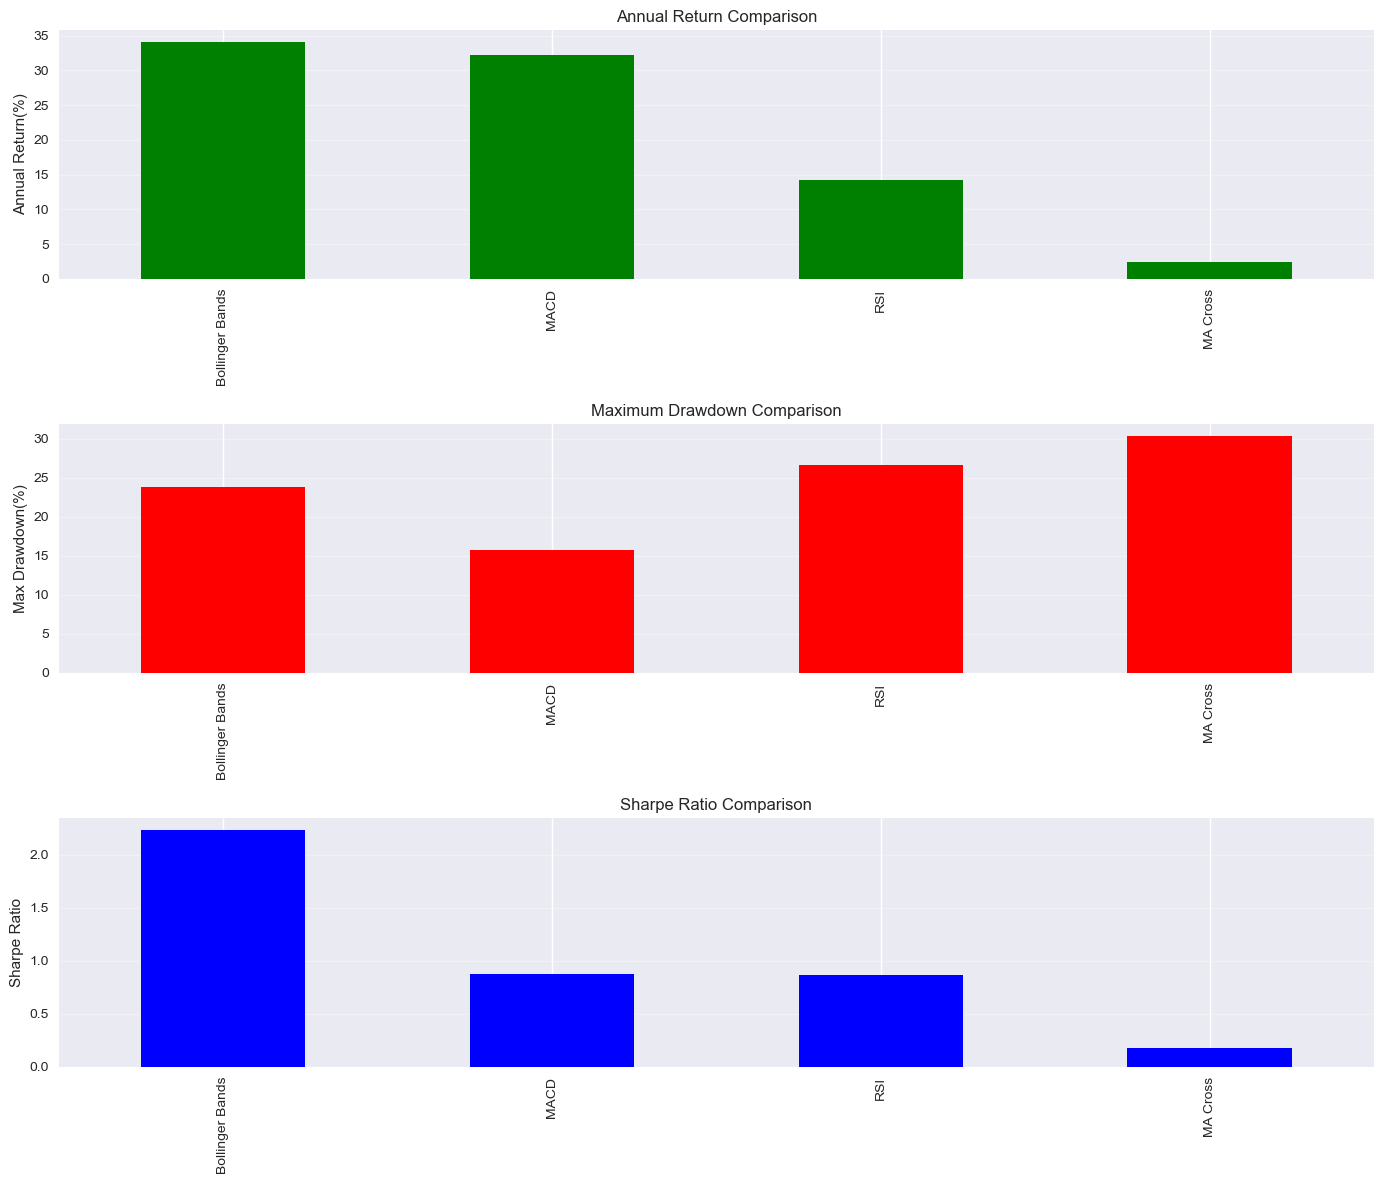

In [57]:
# 5. visualize performance comparison

%matplotlib inline
plt.figure(figsize=(14, 12)) # set figure size

# subplot 1: annual return
plt.subplot(3, 1, 1)
performance_df['Annual Return (%)'].plot(kind='bar', color='green')
plt.title('Annual Return Comparison')
plt.ylabel('Annual Return(%)')
plt.grid(axis='y', alpha=0.3)

# subplot 2: max drawdown
plt.subplot(3, 1, 2)
performance_df['Max Drawdown (%)'].plot(kind='bar', color='red')
plt.title('Maximum Drawdown Comparison')
plt.ylabel('Max Drawdown(%)')
plt.grid(axis='y', alpha=0.3)

# subplot 3: sharpe ratio
plt.subplot(3, 1, 3)
performance_df['Sharpe Ratio'].plot(kind='bar', color='blue')
plt.title('Sharpe Ratio Comparison')
plt.ylabel('Sharpe Ratio')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Strategy parameter optimization

### Optimize the parameters of the best performing strategy:

In [ ]:
# define parameter ranges to optimize
fast_periods = range(5, 30, 5)
slow_periods = range(30, 100, 10)

# container for optimization results
optimization_results = []

# create Cerebro engine for optimization
cerebro = bt.Cerebro(optreturn=False)

# load data
cerebro.adddata(create_bt_data_feed(csv_file))

# add strategy with parameter ranges for optimization
cerebro.optstrategy(
    MovingAverageCrossStrategy,
    fast_period=fast_periods,
    slow_period=slow_periods, 
    ma_type='SMA'
) 

# set initial capital and commission rate
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)

# add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

# run optimization
print("Optimizing parameters, this may take a while...")
results = cerebro.run()

# process optimization results
for run in results:
    fast_period = run[0].params.fast_period
    slow_period = run[0].params.slow_period 
    
    # extract performance metrics
    sharpe = run[0].analyzers.sharpe.get_analysis()["sharperatio"]
    max_dd = run[0].analyzers.drawdown.get_analysis()["max"]["drawdown"]
    annual_return = run[0].analyzers.returns.get_analysis()["rnorm100"]
    
    # store results
    optimization_results.append({
        'fast_period': fast_period,
        'slow_period': slow_period,
        'Sharpe Ratio': sharpe,
        'Max Drawdown (%)': max_dd,
        'Annual Return (%)': annual_return
    })

# convert results to a DataFrame
optimization_df = pd.DataFrame(optimization_results)

# sort by sharpe ratio
optimization_df = optimization_df.sort_values('Sharpe Ratio', ascending=False)

# show top 10 parameter combinations based on sharpe ratio
print("=== Top 10 Parameter Combinations by Sharpe Ratio ===")
optimization_df.head(10)

Optimizing parameters, this may take a while...


In [ ]:
# extract the best parameter combination from optimization results
best_params = optimization_df.iloc[0]

# print the best parameter combination and performance
print(f"Best Parameters: Fast Period={int(best_params['fast_period'])}, Slow Period={int(best_params['slow_period'])}")
print(f"Sharpe Ratio: {best_params['Sharpe Ratio']:.4f}") 
print(f"Max Drawdown: {best_params['Max Drawdown (%)']:.2f}%")
print(f"Annual Return: {best_params['Annual Return (%)']:.2f}%")

# run backtest again using the best parameter combination
data_feed = create_bt_data_feed(csv_file)
best_cerebro, best_strategy, best_results = run_backtest(
    MovingAverageCrossStrategy, 
    data_feed,
    fast_period=int(best_params['fast_period']),
    slow_period=int(best_params['slow_period']),
    ma_type='SMA'
)

# plot the results with candlestick colors
best_cerebro.plot(style='candlestick', barup='green', bardown='red')

## Conclusions and follow-up studies

In this notebook, we compare multiple trading strategies and optimize the parameters of the best performing strategy.

Key Findings:
1. The results of the strategy performance comparison show that different strategies perform differently in different market environments
2. Parameter optimization can significantly improve strategy performance, but the risk of overfitting needs to be kept in mind
3. Good risk management is more important than simply chasing high returns

Follow-up research directions：
1. Combining Multiple Policies to Create Integrated Policies
2. Add stop-loss and risk control mechanisms
3. Extension to multi-asset portfolio strategies
4. Introducing machine learning methods to optimize the strategy
5. Performance of research strategies under different market conditions

Ultimately, successful quantitative trading requires a balance of mathematical modeling, technical implementation, and risk management, with a focus on long-term stable risk-adjusted returns rather than the pursuit of short-term high returns.